 Image:  C110_D2_P1.jpg 
 Angle:  0.0


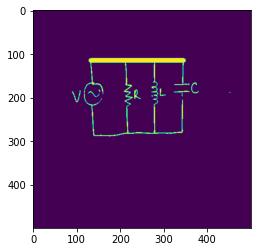

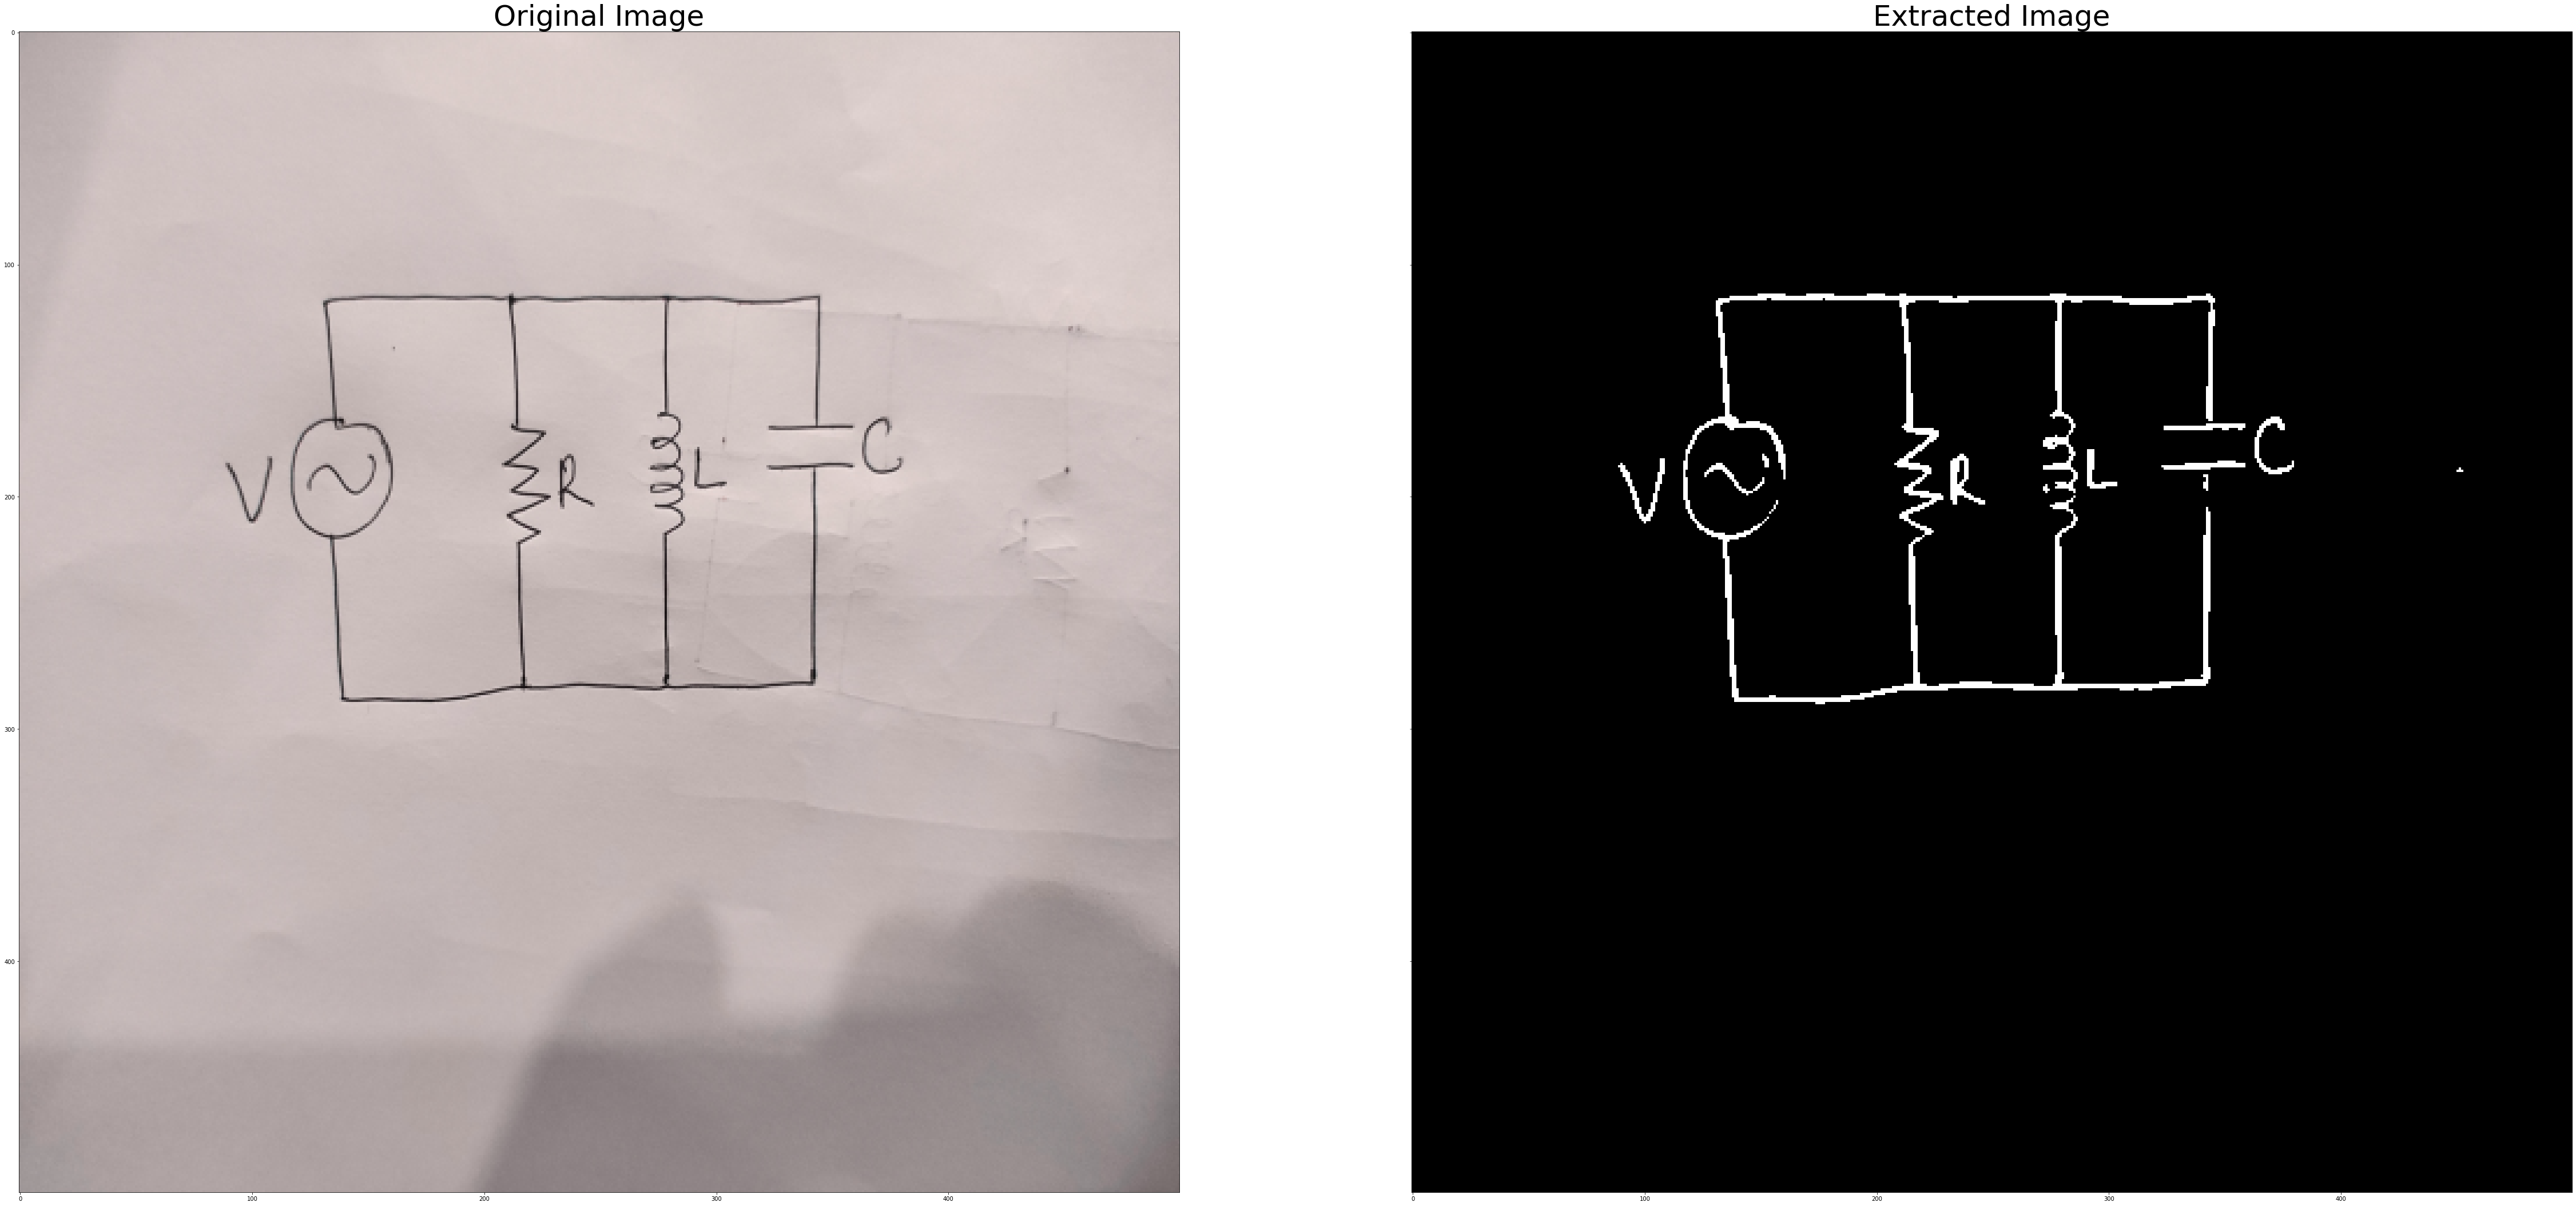

 Image:  C111_D2_P2.jpg 
 Angle:  18.983217059226206


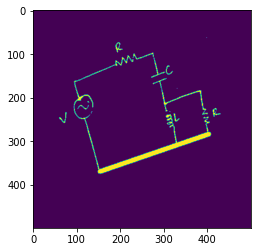

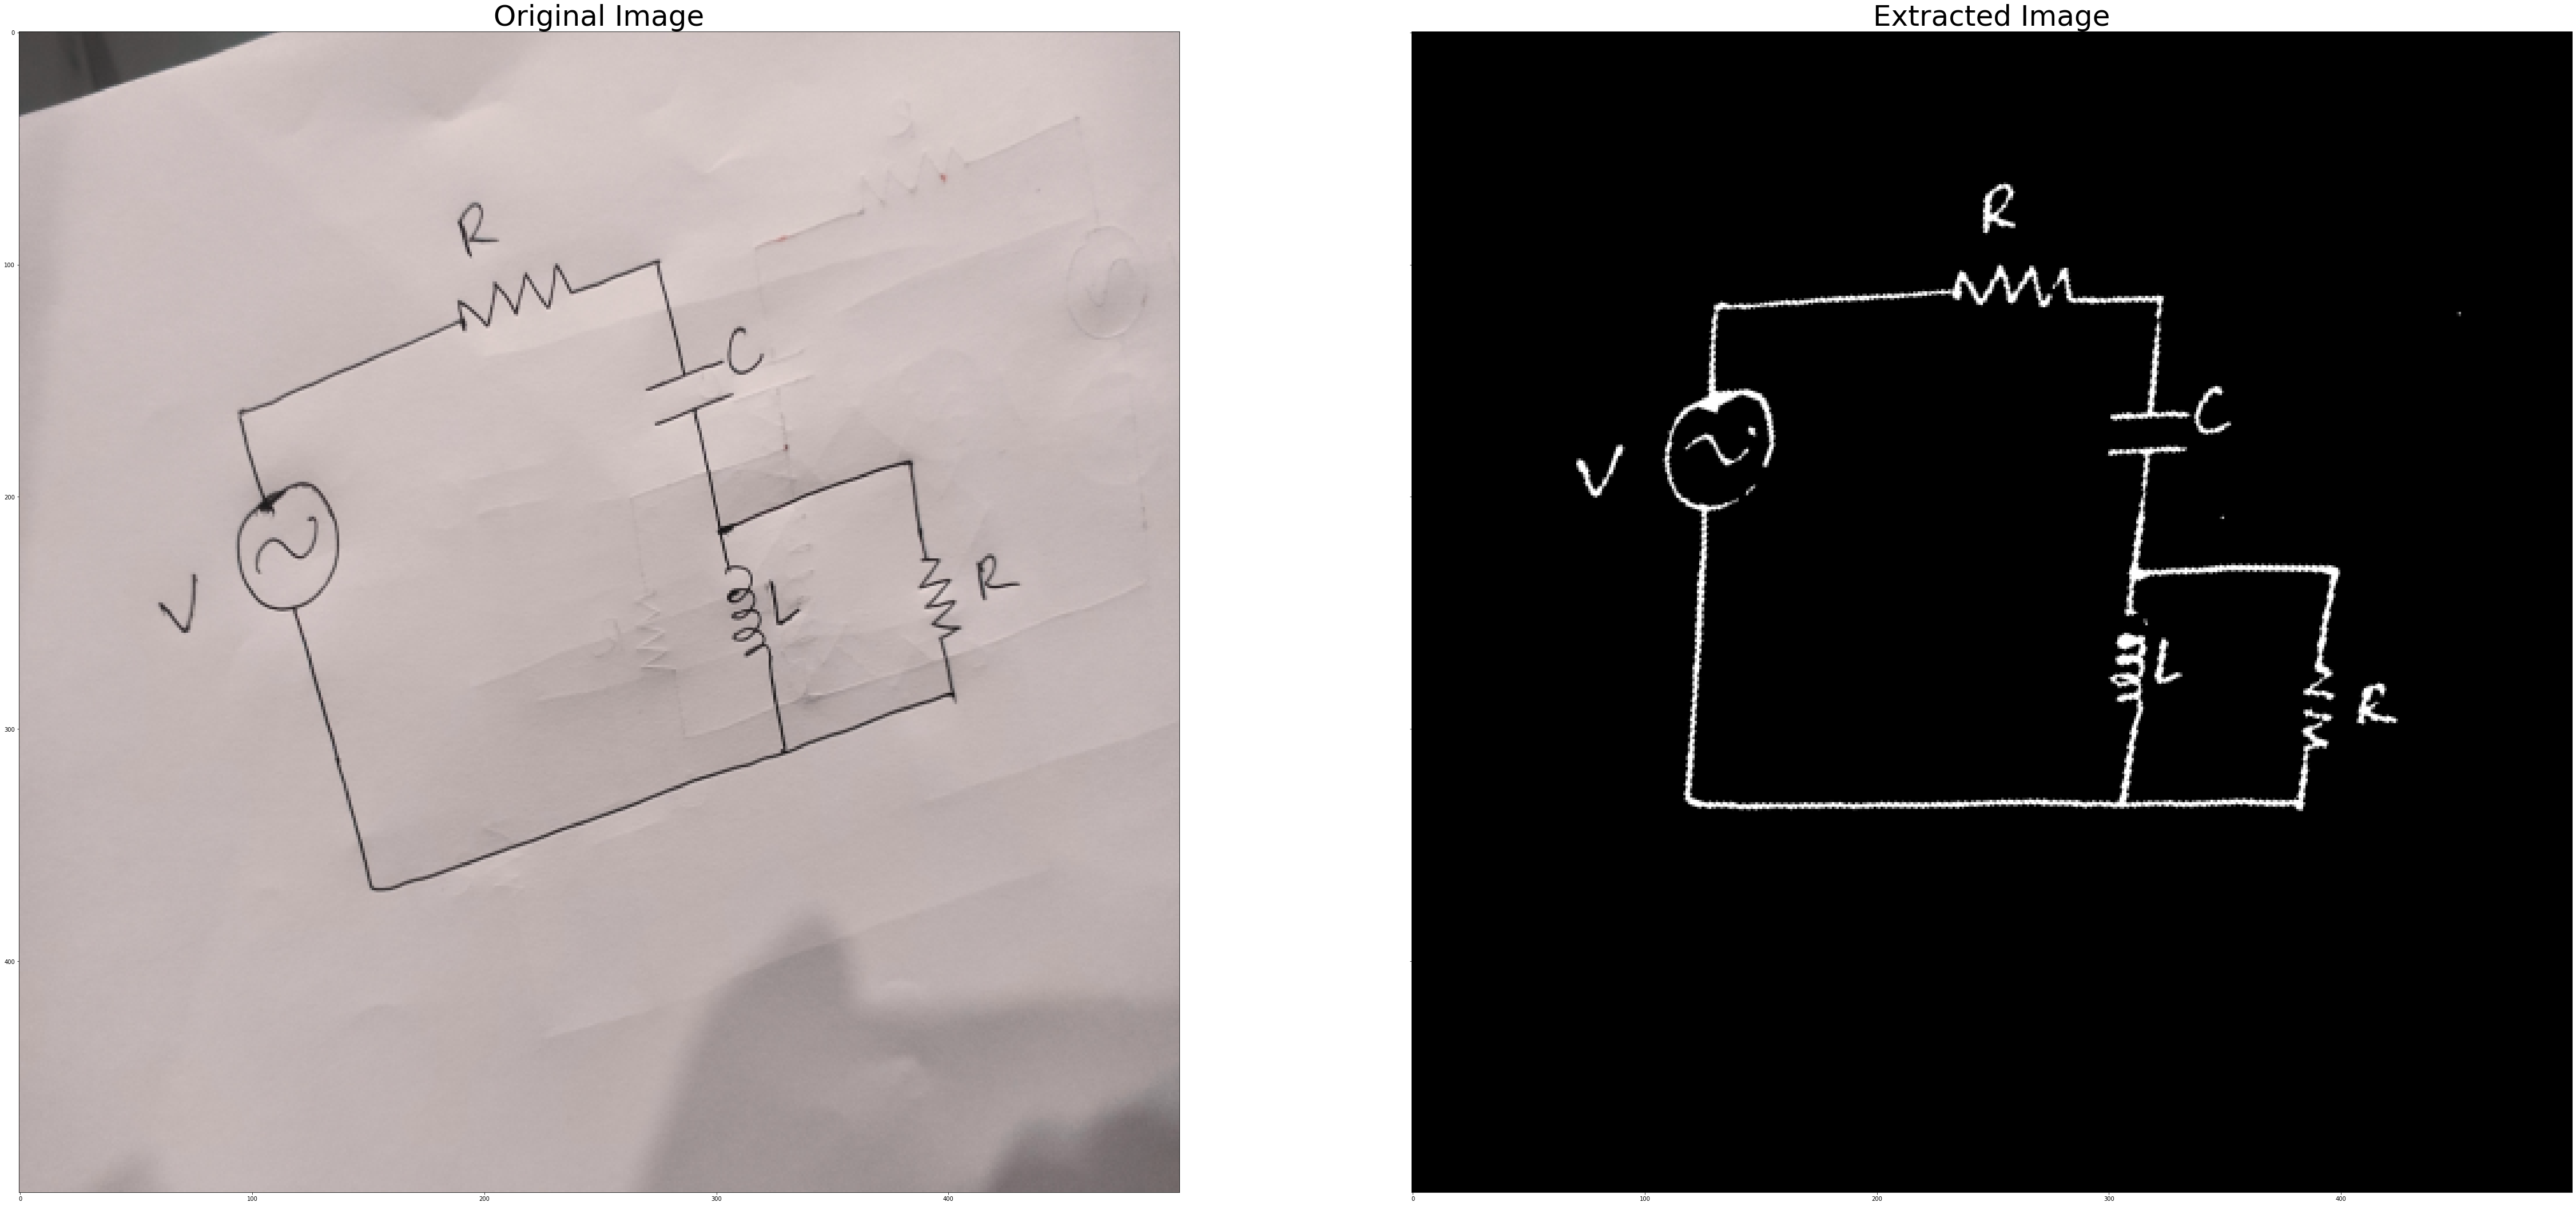

 Image:  C3_D1_P4.jpg 
 Angle:  0.5329686226542378


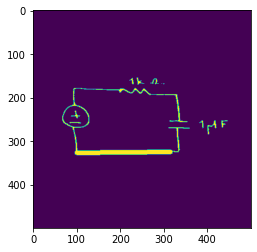

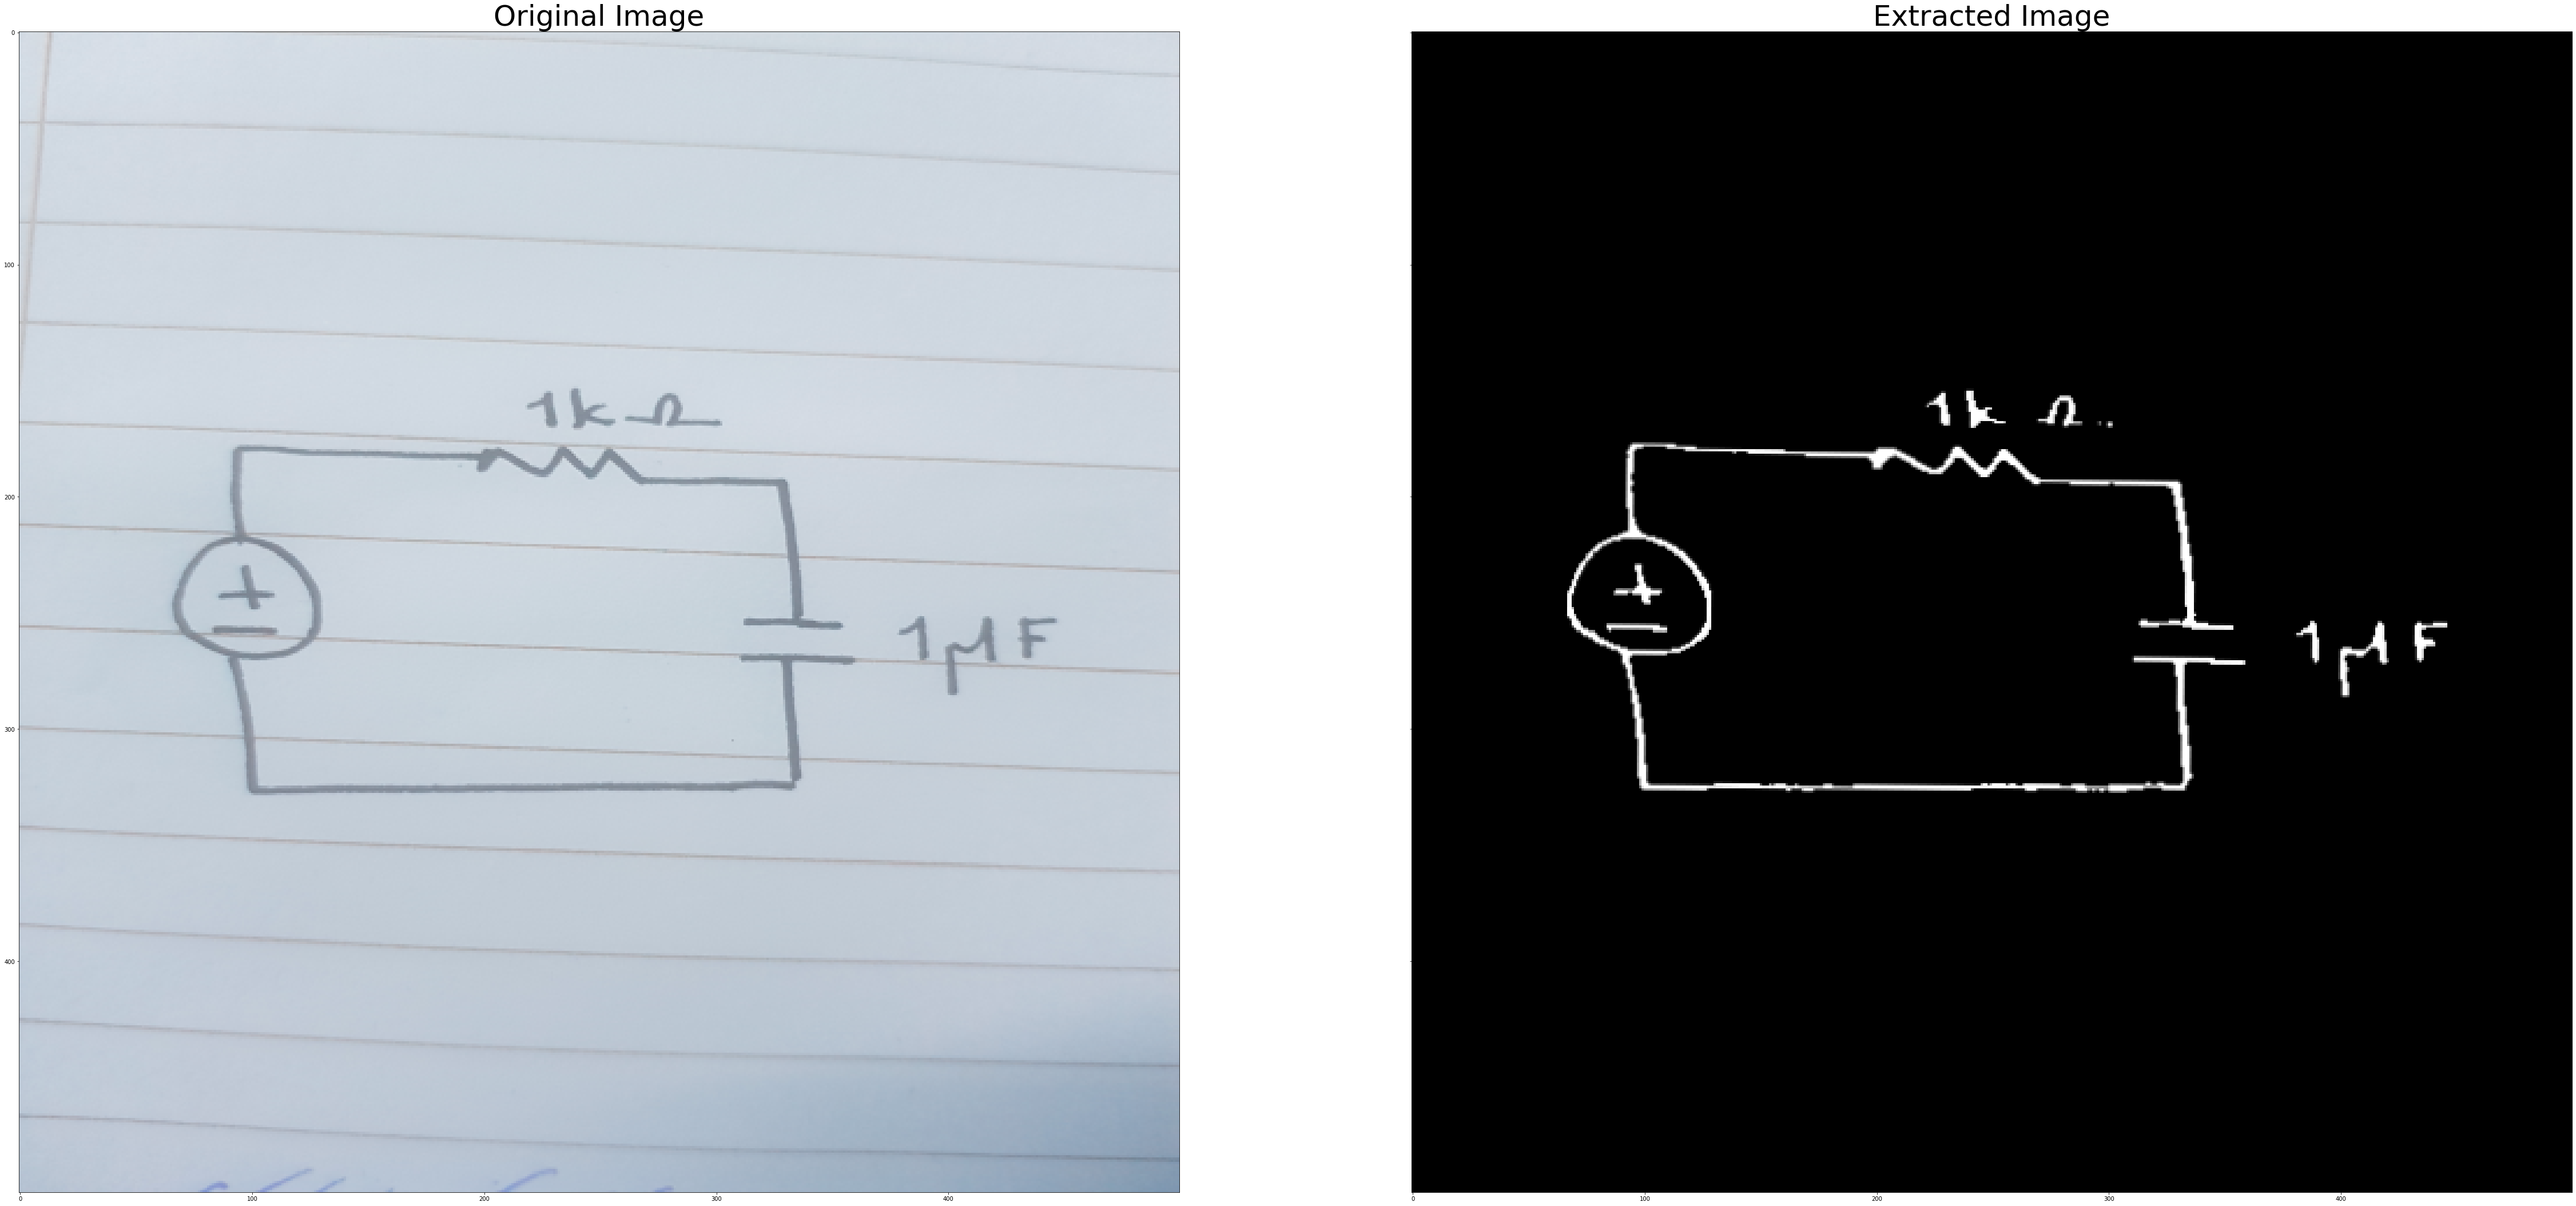

 Image:  hand_drawn_1.jpg 
 Angle:  275.5114774160206


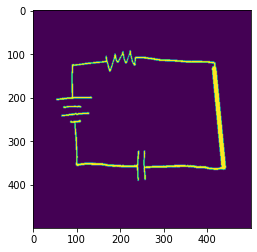

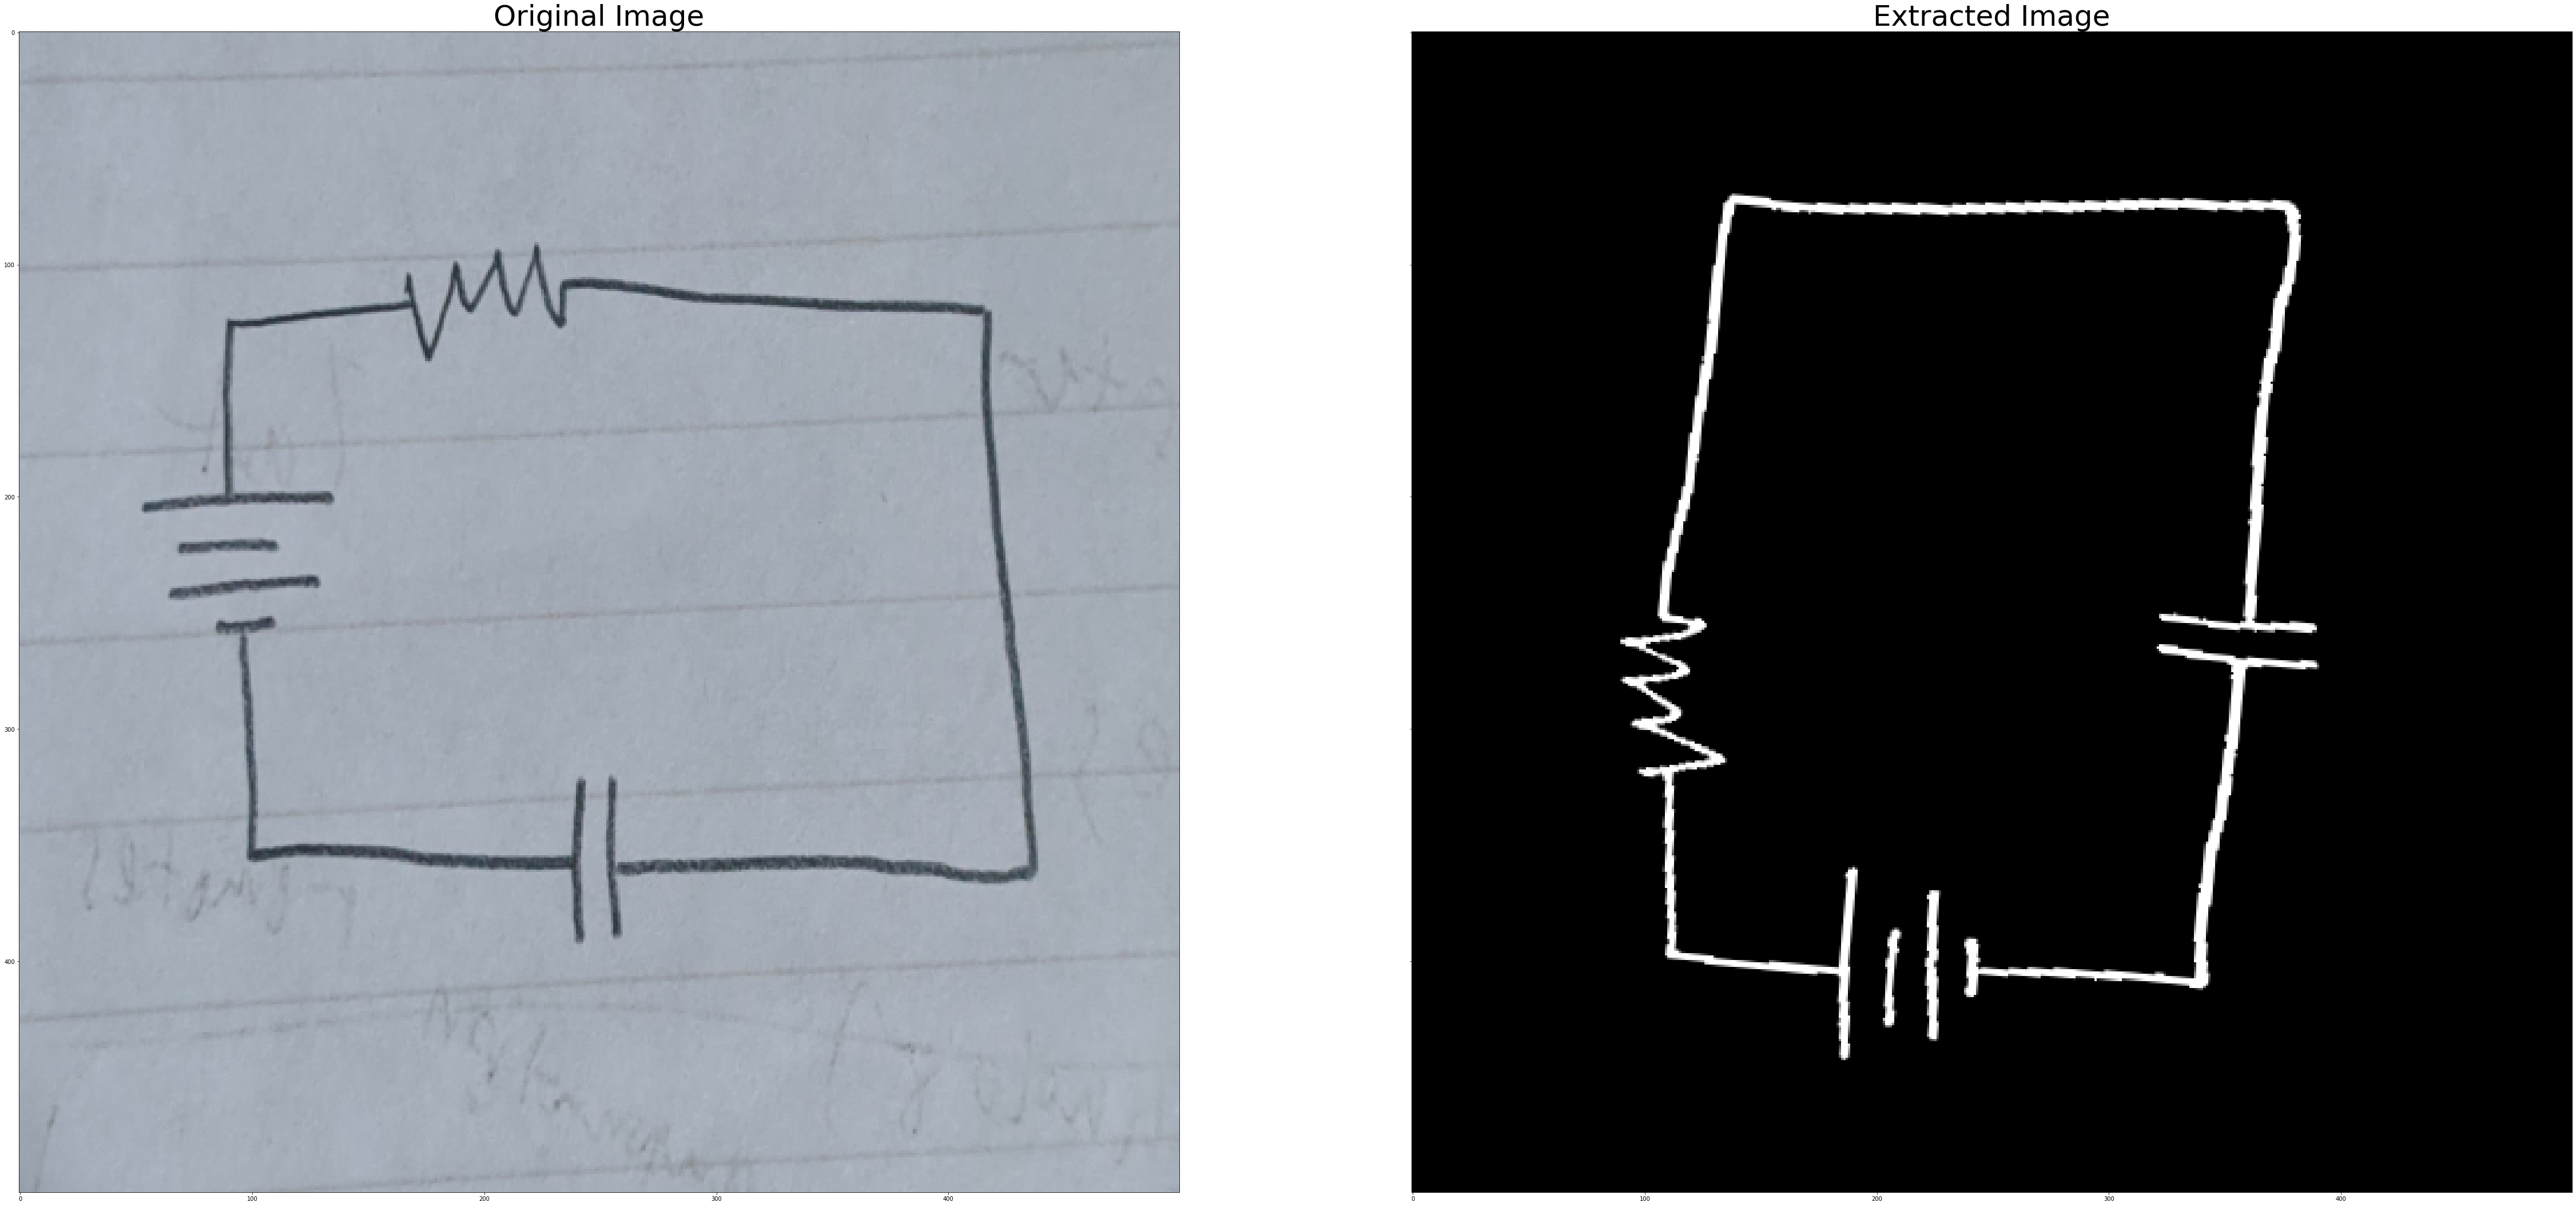

 Image:  hand_drawn_2.jpg 
 Angle:  356.98721249581666


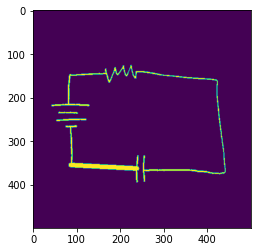

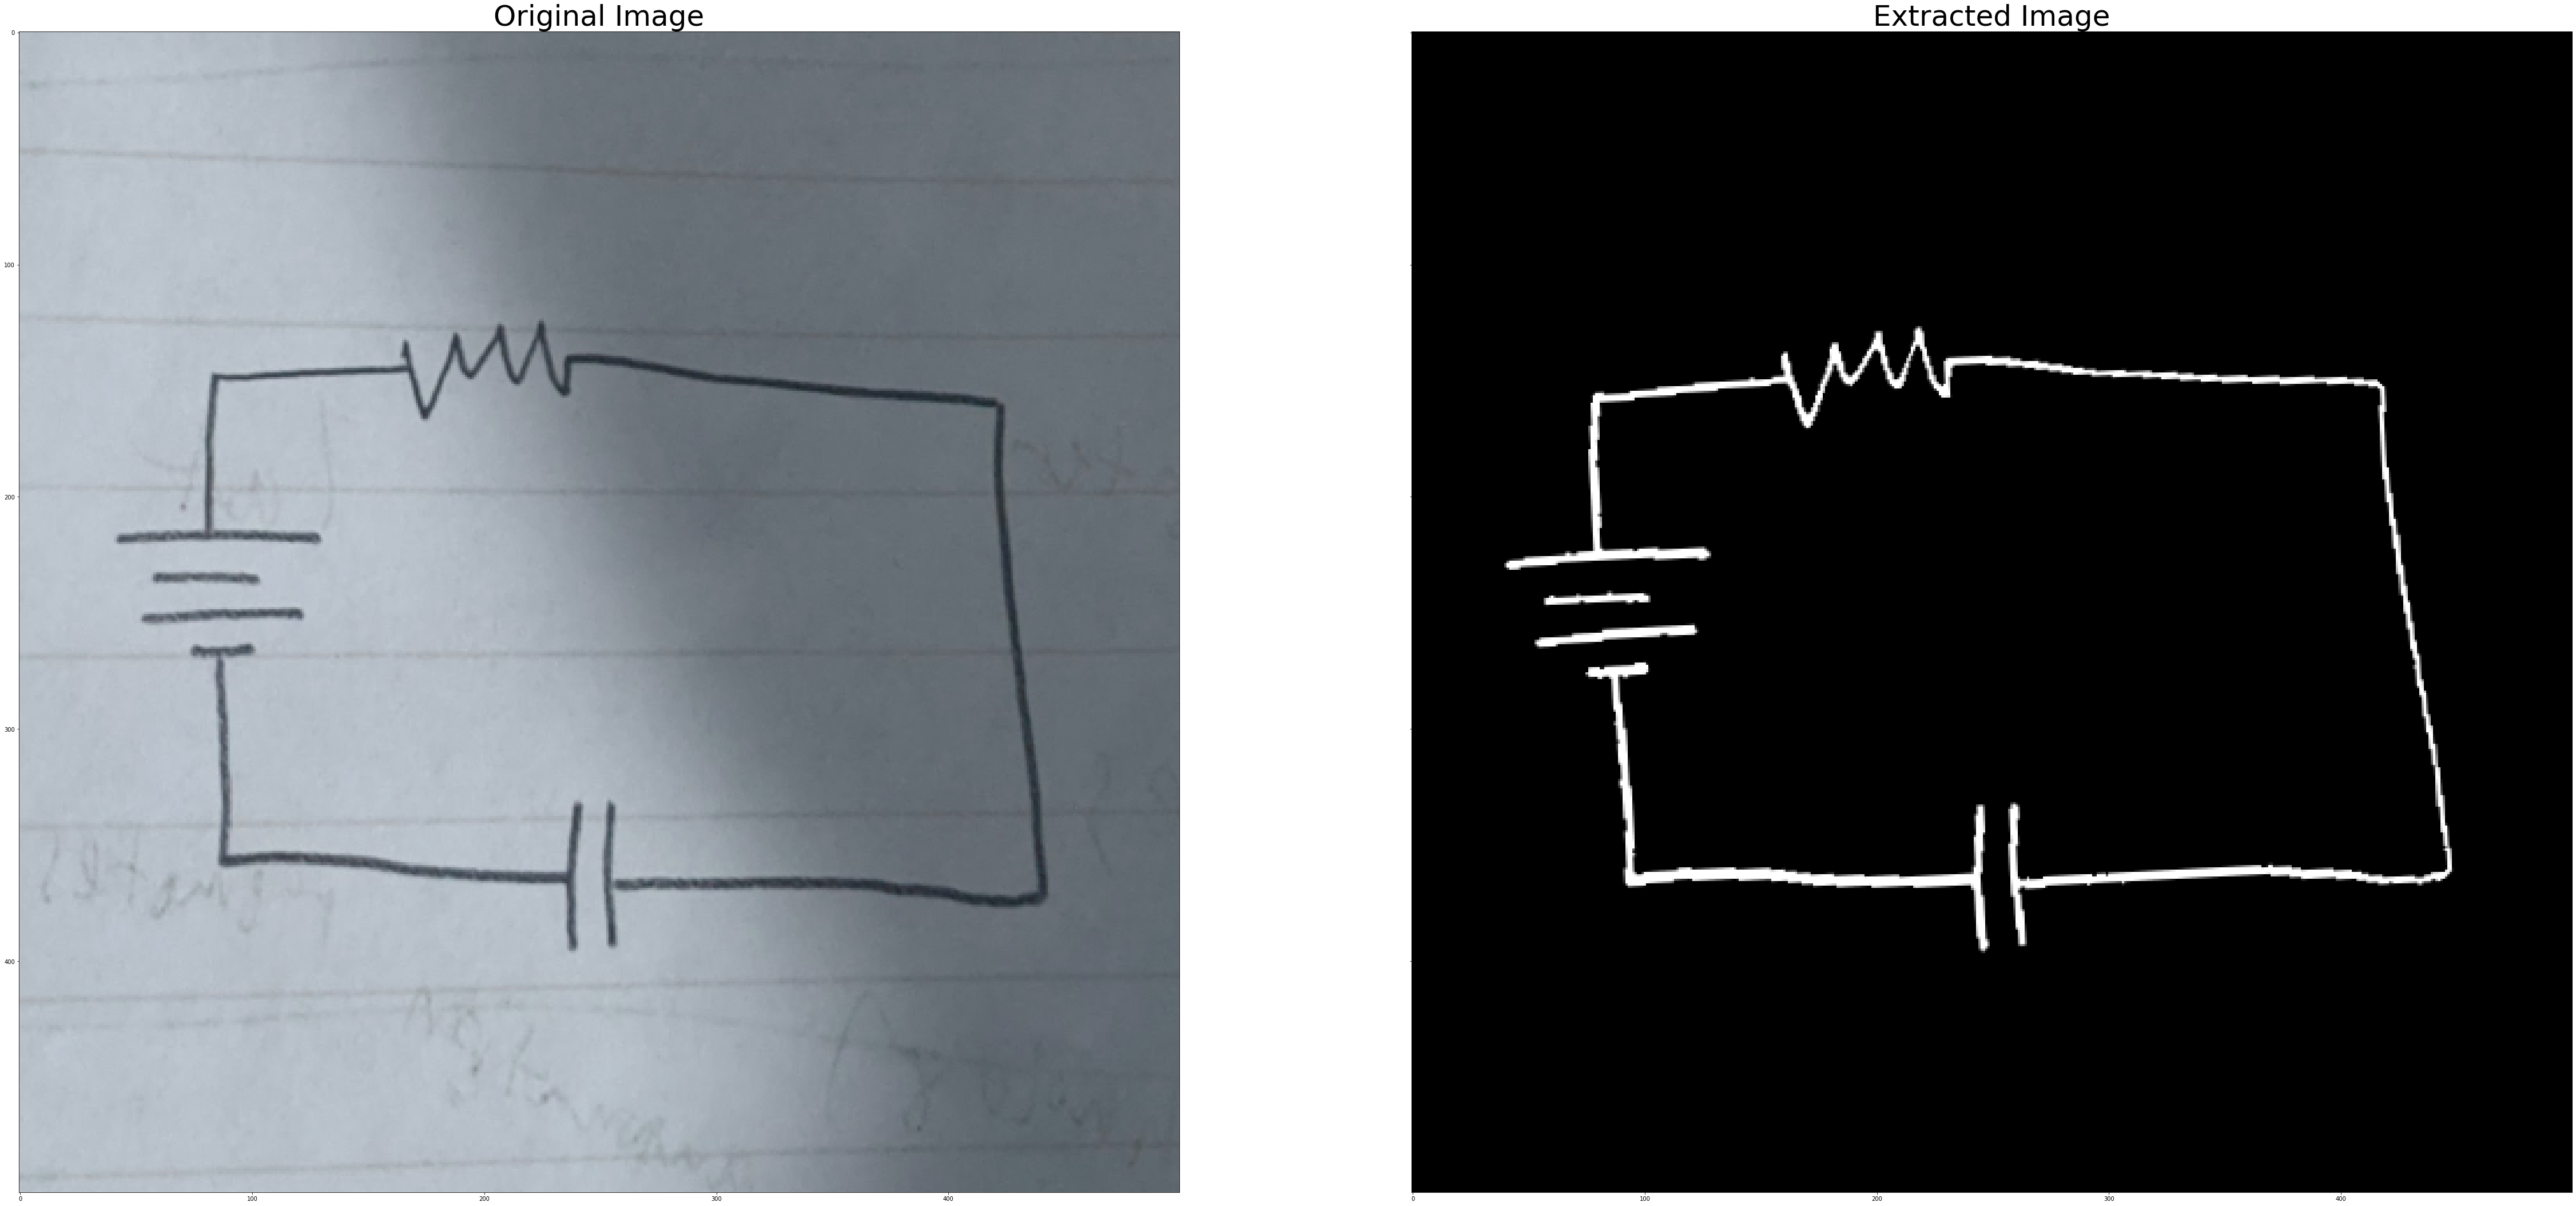

 Image:  hand_drawn_4.jpg 
 Angle:  0.47350805873492163


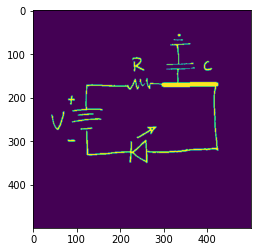

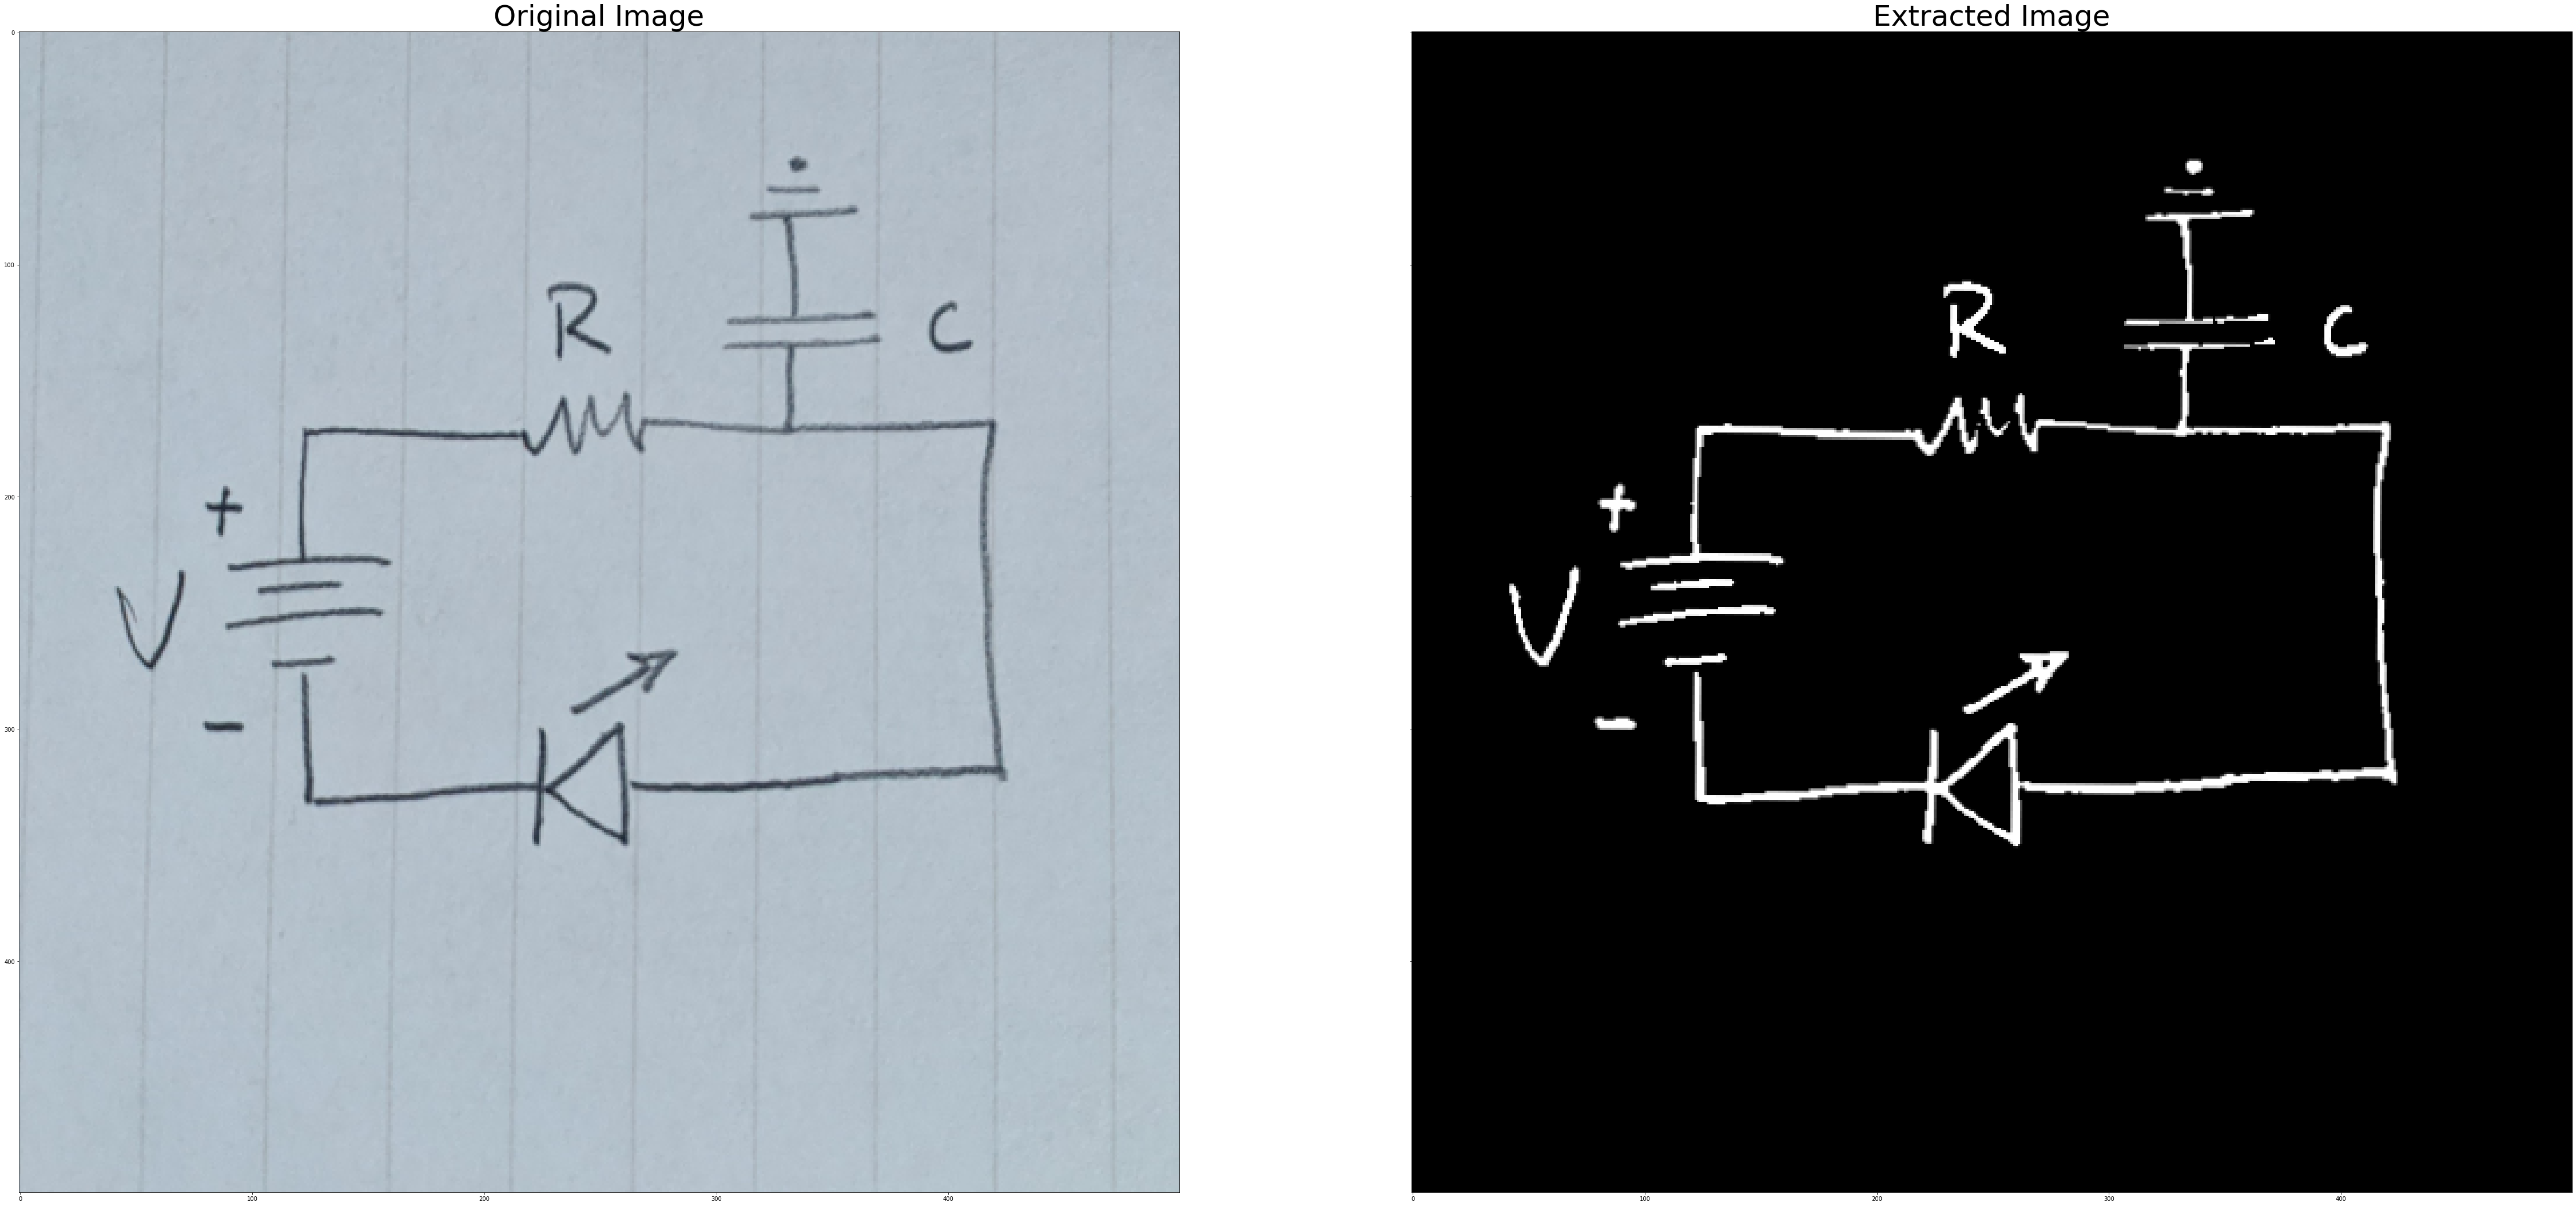

In [2]:
import dippykit as dip
import numpy as np
import cv2 as cv
from PIL import Image
import imutils
from skimage.morphology import thin, skeletonize
from skimage.metrics import structural_similarity as compare_ssim
import os
import math

def resize(img, width = 500, height = 500):
    dim = (width, height)
    # resize image
    resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)
    return resized

def load_images_from_folder(folder):
    images = []
    image_names = []
    for filename in sorted(os.listdir(folder)):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            image_names.append(str(filename))   
    return [image_names, images]

def extract_drawing(img):
    if type(img).__module__ == np.__name__:
        cv_img = img
    else:
        cv_img = change_pil_to_cv(img)
    
    if 2 < cv_img.ndim:
        gray_img = cv.cvtColor(cv_img, cv.COLOR_BGR2GRAY)
    else:
        gray_img = cv_img
    
    blurred_img = cv.GaussianBlur(gray_img, (3, 3), 5, 5)
    blockSize = 199
    threshold_img = cv.adaptiveThreshold(blurred_img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, blockSize , 40)
    
    clahe = cv.createCLAHE(clipLimit=5.0, tileGridSize = (8,8))
    contrast_enhanced_img = clahe.apply(threshold_img) + 30

    dialated_img = np.invert(contrast_enhanced_img)
    while np.average(dialated_img) < 0.025:
        kernel = np.ones((2,2), np.uint8)
        dialated_img = cv.dilate(dialated_img, kernel, iterations=1)

    return np.invert(dialated_img)

def distance(cords):
    cords = cords[0]
    x1 = cords[0]
    y1 = cords[1]
    x2 = cords[2]
    y2 = cords[3]
    return math.hypot(x2 - x1, y2 - y1)

def rotate_image(img):
    if type(img).__module__ == np.__name__:
        cv_img = img
    else:
        cv_img = change_pil_to_cv(img)
    img = cv_img
    if 2 < cv_img.ndim:
        gray_img = np.invert(cv.cvtColor(cv_img, cv.COLOR_BGR2GRAY))
    else:
        gray_img = np.invert(cv_img)
        
    clahe = cv.createCLAHE(clipLimit = 5.0, tileGridSize=(8,8))
    gray_img = clahe.apply(gray_img)
    _,binary_img = cv.threshold(gray_img,15,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    
    output_img = binary_img.copy() 
   
    w,h = img.shape[:2]
    radius1 = int(w/2)
    circle_mask = np.zeros_like(gray_img)
    circle_mask = cv.circle(circle_mask, (w//2,h//2), radius1, (255,255,255), -1)
    binary_img[:,:] *= circle_mask[:,:]

    rho = 1
    theta = np.pi/180/2  # angular resolution [radian]
    AccThreshold = 200  # accumulator threshold – higher = fewer candidates
    lines = cv.HoughLinesP(binary_img[:,:], rho,  theta, AccThreshold, minLineLength=100, maxLineGap=2)
    lines = sorted(lines,reverse = True,key = distance)
    cords = lines[0][0] 
    
    binary_img = cv.line(binary_img, (cords[0], cords[1]), (cords[2], cords[3]), 1, thickness=10)
    dip.figure("asdfasf")
    dip.imshow(binary_img)
    
    angle_rad = math.atan2(cords[1] - cords[3], cords[0] - cords[2])
    angle = 180 - (angle_rad / (np.pi) * 180 )
        
    rotated_img = cv.warpAffine(output_img, \
                     cv.getRotationMatrix2D((output_img.shape[0]/2, output_img.shape[1]/2), -angle, 1),\
                     dsize = output_img.shape[:2])
    return angle, rotated_img

def preprocess_image(img_name, original_image):
    original_image = resize(original_image)
    extract_image = resize(extract_drawing(original_image).astype("uint8"))
    angle, extract_image = rotate_image(extract_image)

    print(" Image: ", img_name,"\n", "Angle: ",angle)
    fig, axes = dip.subplots(nrows=1, ncols=2, figsize=(80, 80), sharex=True, sharey=True)
    ax = axes.ravel()
    fontsize = 50
    ax[0].imshow( original_image , 'gray')
    ax[0].set_title('Original Image', fontsize=fontsize)
    ax[1].imshow( extract_image , 'gray')
    ax[1].set_title('Extracted Image' , fontsize=fontsize)
    dip.show()
    
    return extract_image
    
target_images = load_images_from_folder('target_images')
for target_name, target_img in zip(target_images[0],target_images[1]):
    processed_img = preprocess_image(target_name, target_img)
#     print(processed_img.shape)
    